# MAPSI semaine 5 : Indépendances conditionnelles et réseaux bayésiens



## Exercice : Indépendances conditionnelles et réseaux bayésiens
Dans ce TME, l'objectif est d'apprendre des réseaux bayésiens à partir de bases de données. Hormis la base asia, un exemple jouet relativement petit qui vous permettra de mettre au point les différents algorithmes du TME, et car, les autres bases correspondront à des distributions de probabilité de tailles raisonnables : 

|  nom de la base  |            provenance           | nombre d'evenements elementaires |
|:----------------:|:-------------------------------:|:--------------------------------:|
|       asia       |          BN repository          |                $256     $          |
|       alarm      |          BN repository          |              $10^{16}   $               |
|       adult      | UCI machine learning repository |              $10^{12}   $          |
|        car       | UCI machine learning repository |               $6912     $          |
| agaricus-lepiota | UCI machine learning repository |              $10^{16}   $        |


Apprendre un réseau bayésien consiste à apprendre sa structure graphique ainsi que les paramètres de ses distributions de probabilité conditionnelles. Pour réaliser la deuxième tâche, il suffit d'estimer les paramètres de chaque distribution conditionnelle par maximum de vraisemblance, comme vous l'avez fait dans le TME 3. Ici, nous nous focaliserons donc plutôt sur l'apprentissage de structure. Celle-ci reflétant des indépendances conditionnelles entre variables aléatoires, vous devrez exploiter des tests d'indépendance du χ2 afin d'obtenir des structures graphiques les moins denses possibles (en termes de nombres d'arcs). Ainsi, alarm représente une distribution jointe de plus de $10^{16}$ événements élémentaires mais, quand cette distribution est décomposée grâce au graphe ci-dessous (les noeuds représentant les variables aléatoires), elle peut être décrite (sans perte d'informations) à l'aide de seulement 752 paramètres. Comme nous l'avons vu en cours, cette représentation permet également d'effectuer très rapidement des calculs probabilistes.

![Image ](tme5_alarm.png)

### 1. Lecture des données

Dans le code ci-dessous, la fonction `read_csv : string -> (string np.array, int np.2D-array, dico{string -> int} np.array)` vous permettra de lire les données des bases sur lesquelles vous allez travailler, et de les organiser sous une forme adéquate. Par exemple, une base de données est un fichier de la forme : 

```
 X_0,X_1,X_2,X_3
 haut,gauche,petit,bas
 bas,droite,grand,gauche
 bas,gauche,moyen,bas
```


Dans cette base, nous avons 4 variables aléatoires nommées X_0, X_1, X_2, et X_3, et 3 enregistrements qui représentent des instanciations (observées) de ces 4 variables. Ainsi, X_0 a pour valeurs haut, bas et bas, X_1 a pour valeurs gauche, droite, gauche, etc.

La fonction `read_csv` prend en argument le nom d'un fichier CSV contenant une base de données et renvoie un triplet composé de :



- 1 tableau numpy de strings contenant les noms des variables aléatoires. Par exemple, pour la base ci-dessus, ce tableau correspond à: 
```python
 n.array (['X_0', 'X_1', 'X_2', 'X_3'])
```

- un tableau numpy 2D contenant les données du fichier CSV encodées sous forme numérique (les valeurs des variables aléatoires sont transformées en nombres entiers): chaque ligne de ce tableau représente les intanciations d'une variable aléatoire et chaque colonne représente un enregistrement de la base de données, c'est-à-dire une instanciation/observation de toutes les variables aléatoires. Pour la base ci-dessus, nous obtiendrions le tableau ci-dessous (la signification des nombres est indiquée dans le dictionnaire précisé plus bas): 
```python
 np.array ( [ [0, 1, 1],   # instanciations de la variable X_0
              [0, 1, 0],    # instanciations de la variable X_1
              [0, 1, 2],    # instanciations de la variable X_2
              [0, 1, 0]] )  # instanciations de la variable X_3
```

Ainsi, les valeurs observées de la première variable aléatoire X_0 correspondent à la première ligne du tableau (0, 1 et 1). La première colonne correspond à une observation de toutes les variables (X_0=0,X_1=0,X_2=0,X_3=0). C'est essentiellement sur ce tableau numpy que vous travaillerez dans ce TME. 


- un tableau numpy de dictionnaires faisant la correspondance, pour chaque variable aléatoire, entre l'encodage numérique du tableau 2D ci-dessus et les données du fichier CSV (le 1er dictionnaire correspond à la variable de la 1ère colonne du CSV, le 2ème dictionnaire à celle de la 2ème colonne, etc.). Ainsi, le dictionnaire est égal à : 

```python
np.array( [ {'haut': 0, 'bas': 1},                  # encodage variable X_0
             {'gauche': 0, 'droite': 1},            # encodage variable X_1
             {'petit': 0, 'grand': 1, 'moyen': 2 }, # encodage variable X_2
             {'bas': 0, 'gauche': 1} ] )            # encodage variable X_3
```



On peut ainsi reconstituer le CSV d'origine. Par exemple, la première colonne du tableau 2D ci-dessus, qui est égale à 0,0,0,0 correspond à haut,gauche,petit,bas: "haut" correspondant au 0 de la première variable aléatoire, "gauche" correspondant au 0 de la 2ème variable, etc. 

Lisez-le fichier [tme5_asia.csv](tme5_asia.csv) à l'aide de la fonction read_csv ci-dessous: la dernière instruction, `names, data, dico = read_csv ( "tme5_asia.csv" )`, vous permettra de récupérer, séparément, les trois champs du triplet renvoyé par la fonction read_csv. 

In [1]:
# -*- coding: utf-8 -*-

import numpy as np

# fonction pour transformer les données brutes en nombres de 0 à n-1
def translate_data ( data ):
    # création des structures de données à retourner
    nb_variables = data.shape[0]
    nb_observations = data.shape[1] - 1 # - nom variable
    res_data = np.zeros ( (nb_variables, nb_observations ), int )
    res_dico = np.empty ( nb_variables, dtype=object )

    # pour chaque variable, faire la traduction
    for i in range ( nb_variables ):
        res_dico[i] = {}
        index = 0
        for j in range ( 1, nb_observations + 1 ):
            # si l'observation n'existe pas dans le dictionnaire, la rajouter
            if data[i,j] not in res_dico[i]:
                res_dico[i].update ( { data[i,j] : index } )
                index += 1
            # rajouter la traduction dans le tableau de données à retourner
            res_data[i,j-1] = res_dico[i][data[i,j]]
    return ( res_data, res_dico )


# fonction pour lire les données de la base d'apprentissage
def read_csv ( filename ):
    data = np.loadtxt ( filename, delimiter=',', dtype=np.str ).T
    names = data[:,0].copy ()
    data, dico = translate_data ( data )
    return names, data, dico

# names : tableau contenant les noms des variables aléatoires
# data  : tableau 2D contenant les instanciations des variables aléatoires
# dico  : tableau de dictionnaires contenant la correspondance (valeur de variable -> nombre)

names, data, dico = read_csv ( "tme5_asia.csv" )
print(names)
print(data)
print(dico)

['visit_to_Asia?' 'smoking?' 'tuberculosis?' 'lung_cancer?' 'bronchitis?'
 'tuberculos_or_cancer?' 'dyspnoea?' 'positive_XraY?']
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 1 ... 1 0 0]
 [0 1 1 ... 1 1 1]]
[{'true': 0, 'false': 1} {'false': 0, 'true': 1} {'true': 0, 'false': 1}
 {'false': 0, 'true': 1} {'false': 0, 'true': 1} {'false': 0, 'true': 1}
 {'false': 0, 'true': 1} {'false': 0, 'true': 1}]


### 2.  Statistique du $\chi^2$ conditionnel


Soit deux variables aléatoires $X$ et $Y$. Appelons $N_{xy}$, $N_x$ et $N_y$, respectivement, le nombre d'occurrences du couple $(X=x,Y=y)$ et des singletons $X=x$ et $Y=y$ dans la base de données. Alors, comme indiqué dans le cours 5, la statistique du $\chi^2$ de $X$ et $Y$ est égale à : 


$$\chi^2_{X,Y} = \sum_x\sum_y\frac{\left(N_{xy} - \frac{N_x \times N_y}{N}\right)^2}{\frac{N_x \times N_y}{N}}$$

où {$N$} représente le nombre de lignes de la base de données. Cette formule permet de tester l'indépendance entre les deux variables {$X$} et {$Y$}. On peut aisément généraliser celle-ci pour tester des indépendances conditionnellement à un ensemble de variables {$\mathbf{Z}$}:

$$\chi^2_{X,Y|\mathbf{Z}} = \sum_x\sum_y\sum_{\mathbf{z}}\frac{\left(N_{xy\mathbf{z}} - \frac{N_{x\mathbf{z}} \times N_{y\mathbf{z}}}{N_{\mathbf{z}}}\right)^2}{\frac{N_{x\mathbf{z}} \times N_{y\mathbf{z}}}{N_{\mathbf{z}}}}$$

où $N_{xy\mathbf{z}}$, $N_{x\mathbf{z}}$, $N_{y\mathbf{z}}$ et $N_{\mathbf{z}}$ représentent, respectivement, le nombre d'occurrences du triplet $(X=x,Y=y,\mathbf{Z} = \mathbf{z})$, des couples $(X=x,\mathbf{Z} = \mathbf{z})$ et $(Y=y,\mathbf{Z} = \mathbf{z})$, et du singleton $\mathbf{Z} = \mathbf{z}$. Ainsi, si $\mathbf{Z}$ est un ensemble de 3 variables aléatoires $(A,B,C)$, les valeurs $\mathbf{z}$ seront des triplets $(a,b,c)$.

Afin de vous aider à calculer ces $\chi^2$, vous pourrez utiliser la fonction **create_contingency_table** `: int np.2D-array x dico{string -> int} np.array x int x int x int list -> (int, np.2D-array) np.array` ci-dessous. Celle-ci prend en argument le tableau 2D numpy `data` et le tableau de dictionnaires `dico` retournés à la fin de la question 1, ainsi que l'index `x` d'une variable aléatoire (0 = 1ère variable aléatoire (celle de la 1ère ligne de `data`), 1 = 2ème variable, _etc._), l'index `y` d'une autre variable et une liste `z` d'index d'autres variables aléatoires. Elle renvoie un tableau de couples ({$N_{\mathbf{z}}, T_{X,Y,\mathbf{z}})$}, pour tous les {$\mathbf{z} \in\mathbf{Z}$}, où:

*   $N_{\mathbf{z}}$ représente le nombre d'occurences de {$Z=z$} dans la base de données. Par exemple, si la base de données est la suivante :

```
 X_0,X_1,X_2,X_3
 haut,gauche,petit,bas
 bas,droite,grand,gauche
 bas,gauche,moyen,bas
```

nous avons vu plus haut que le tableau data est égal à : 

```python
data = np.array ( [ [0, 1, 1],    # instanciations de la variable X_0
                     [0, 1, 0],    # instanciations de la variable X_1
                     [0, 1, 2],    # instanciations de la variable X_2
                     [0, 1, 0]] )  # instanciations de la variable X_3
```


L'application de **create_contingency_table ( data, dico, 0, 2, [3] ) **renverra le tableau: 
```python
resultat = array([ (2, array([[ 1.,  0.,  0.],        # Z = 0 => N_{Z=0} = 2
                               [ 0.,  0.,  1.]])),
                    (1, array([[ 0.,  0.,  0.],        # Z = 1 => N_{Z=1} = 1
                               [ 0.,  1.,  0.]])) ])
```


C'est a dire : 
Si $X_3=0$

|  	| $X_2$=0| $X_2$=1 	| $X_2$=3 	|
|:-------:	|:-------:	|:-------:	|:-------:	|
| $X_0$=0 	|          1 	| 0 	| 0 	|
| $X_0$=1 	|          0 	| 0 	| 1 	|

Si $X_3=1$

|  	| $X_2$=0| $X_2$=1 	| $X_2$=3 	|
|:-------:	|:-------:	|:-------:	|:-------:	|
| $X_0$=0 	|          0 	| 0 	| 0 	|
| $X_0$=1 	|          0 	| 1 	| 0 	|



En effet le paramètre `[3]` indique que $\mathbf{Z}$ est constitué uniquement de la quatrième variable de la base, autrement dit $X_3$. La dernière ligne du tableau `data` indique les instanciations de X_3 et l'on peut observer que la valeur 0 apparaît 2 fois et la valeur 1 apparaît une fois. On a donc $N_{Z=0} = 2$ et $N_{Z=1} = 1$. On peut observer que les valeurs de $N_{\mathbf{Z}}$ sont bien les premiers éléments des couples de `resultat`. Lorsque $\mathbf{Z} = \emptyset$, `resultat` est un tableau avec un seul couple dont le premier élément correspond précisément à $N$, le nombre d'enregistrements de la base de données.

*  $T_{X,Y,\mathbf{z}}$ est un tableau 2D contenant le nombre d'occurrences $N_{xy\mathbf{z}}$ des couples $(X=x,Y=y)$ lorsque $\mathbf{Z}=\mathbf{z}$. La première dimension de ce tableau (les lignes) correspondent aux différentes valeurs de $X$ et la deuxième (les colonnes) à celles de {$Y$}. Ainsi, le tableau en haut à droite de `resultat` est obtenu de la manière suivante: ce tableau correspond à des occurrences de $(X,Y)$ lorsque $\mathbf{Z}=0$. on commence donc par extraire de `data` le sous-tableau correspondant à la première et à la troisième colonne (les colonnes où X_3=0) et on ne retient que les lignes correspondant à X_0 et X_2 (cf. les paramètres 0 et 2 passés en arguments de **create_contingency_table**). On obtient donc le sous-tableau:

```python
np.array ( [ [0, 1],    # instanciations de la variable X_0
              [0, 2]] )  # instanciations de la variable X_2
```

Ce tableau nous indique que, lorsque $X_3=0$, les couples $(X_0=0,X_2=0)$ et $(X_0=1,X_2=2)$ apparaissent une seule fois et ce sont les seuls couples qui apparaissent dans la base de données. C'est précisément ce que représente le tableau en haut à droite de `resultat`

In [2]:
# etant donné une BD data et son dictionnaire, cette fonction crée le
# tableau de contingence de (x,y) | z

def create_contingency_table ( data, dico, x, y, z ):
    # détermination de la taille de z
    size_z = 1
    offset_z = np.zeros ( len ( z ) )
    j = 0
    for i in z:
        offset_z[j] = size_z      
        size_z *= len ( dico[i] )
        j += 1

    # création du tableau de contingence
    res = np.zeros ( size_z, dtype = object )

    # remplissage du tableau de contingence
    if size_z != 1:
        z_values = np.apply_along_axis ( lambda val_z : val_z.dot ( offset_z ),
                                         1, data[z,:].T )
        i = 0
        while i < size_z:
            indices, = np.where ( z_values == i )
            a,b,c = np.histogram2d ( data[x,indices], data[y,indices],
                                     bins = [ len ( dico[x] ), len (dico[y] ) ] )
            res[i] = ( indices.size, a )
            i += 1
    else:
        a,b,c = np.histogram2d ( data[x,:], data[y,:],
                                 bins = [ len ( dico[x] ), len (dico[y] ) ] )
        res[0] = ( data.shape[1], a )
    return res


In [3]:
resultat=create_contingency_table ( data, dico, 0, 2, [3] ) 
print(resultat[0][1])


[[  0. 102.]
 [  0.   1.]]



En utilisant la structure retournée par la fonction **create_contingency_table**, écrivez une fonction **sufficient_statistics**`: int np.2D-array x dico{string -> int} np.array x int x int x int list -> float` qui prend les mêmes arguments que la fonction **create_contingency_table** et qui renvoie la valeur de $\chi^2_{X,Y|\mathbf{Z}}$. Vous pourrez tirer profit du fait que $N_{x\mathbf{z}} = \sum_{y} N_{xy\mathbf{z}}$ et $N_{y\mathbf{z}} = \sum_{x} N_{xy\mathbf{z}}$, ce qui revient à faire des sommes sur chaque ligne ou chaque colonne des tableaux $T_{X,Y,\mathbf{z}}$. 

**Attention :** il peut arriver que certains $N_{\mathbf{z}}$ soient égaux à 0\. Dans ce cas, vous ne tiendrez pas compte des $N_{xy\mathbf{z}}$, $N_{x\mathbf{z}}$ et $N_{y\mathbf{z}}$ correspondants dans la formule de $\chi^2_{X,Y|\mathbf{Z}}$ (car vous feriez des divisions par 0, ce qui est mal).


In [22]:
def sufficient_statistics ( data, dico, x, y, z ):
    # création du tableau de contingence
    table = create_contingency_table ( data, dico, x, y, z )
    return sufficient_statistics2 ( table, data, dico, x, y, z )

# On utilise une sous fonctions afin de factoriser le code
def sufficient_statistics2 ( table, data, dico, x, y, z ):
    # création du tableau de contingence
    nb_z = table.shape[0]
    nb_x, nb_y = table[0][1].shape
    
    ### votre code
        
    qui2_xy_z=0
    for _z in range(nb_z):
        N_z = table[_z][0]
        N_xz = table[_z][1].sum(1)
        N_yz = table[_z][1].sum(0)
        
        for _x in range(nb_x):
            for _y in range(nb_y):
                if N_z != 0:
                    temps = N_xz[_x] * N_yz[_y] / N_z
                    N_xyz = table[_z][1][_x][_y] 
                    if temps != 0:
                        qui2_xy_z += (N_xyz - temps ) ** 2 /(temps)
    
    return qui2_xy_z



Vous pourrez vérifier la validité de vos calculs: en utilisant la base de données "2015_tme5_asia.csv", vous devriez obtenir les résultats suivants :


| appel de la fonction 	| résultat 	|
|--------------------------------------------------	|--------------------	|
| sufficient_statistics ( data, dico, 1,2,[3]) 	| 3.9466591186668296 	|
| sufficient_statistics ( data, dico, 0,1,[2,3]) 	| 16.355207462350094 	|
| sufficient_statistics ( data, dico, 1,3,[2]) 	| 81.807449348140295 	|
| sufficient_statistics ( data, dico, 5,2,[1,3,6]) 	| 1897.0 	|
| sufficient_statistics ( data, dico, 0,7,[4,5]) 	| 3.2223237760949699 	|
| sufficient_statistics ( data, dico, 2,3,[5]) 	| 130.0 	|

In [23]:
print(sufficient_statistics ( data, dico, 1,2,[3]) )
print(sufficient_statistics ( data, dico, 0,1,[2,3]) ) 
print(sufficient_statistics ( data, dico, 1,3,[2])  )
print(sufficient_statistics ( data, dico, 5,2,[1,3,6] )) 
print(sufficient_statistics ( data, dico, 0,7,[4,5]) )
print(sufficient_statistics ( data, dico, 2,3,[5]) )

3.9466591186668296
16.35520746235009
81.8074493481403
1897.0
3.2223237760949694
130.0


## 3. Statistique du $\chi^2$ et degré de liberté

Modifiez votre fonction **sufficient_statistics** afin qu'elle ne renvoie plus seulement $\chi^2_{X,Y|\mathbf{Z}}$ mais plutôt un couple ($\chi^2_{X,Y|\mathbf{Z}}$,DoF), où DoF est le nombre de degrés de liberté de votre statistique. Celui-ci est égal à :

$$(|X|-1) \times (|Y|-1) \times |\{\mathbf{z} : N_{\mathbf{z}} \neq 0\}| $$

où $|X|$ représente le nombre de valeurs possibles que peut prendre la variable $X$, autrement dit, c'est la taille de son dictionnaire. Le dernier terme de l'équation est simplement le nombre de $N_{\mathbf{z}}$ différents de 0.

Vous pourrez vérifier la validité de vos calculs: en utilisant la base de données "2015_tme5_asia.csv", vous devriez obtenir les résultats suivants:

| appel de la fonction 	| résultat 	|
|:------------------------------------------------:	|:-----------------------:	|
| sufficient_statistics ( data, dico, 1,2,[3]) 	| (3.9466591186668296, 2) 	|
| sufficient_statistics ( data, dico, 0,1,[2,3]) 	| (16.355207462350094, 3) 	|
| sufficient_statistics ( data, dico, 1,3,[2]) 	| (81.807449348140295, 2) 	|
| sufficient_statistics ( data, dico, 5,2,[1,3,6]) 	| (1897.0, 8) 	|
| sufficient_statistics ( data, dico, 0,7,[4,5]) 	| (3.2223237760949699, 4) 	|
| sufficient_statistics ( data, dico, 2,3,[5]) 	| (130.0, 2) 	|

In [25]:
def sufficient_statistics ( data, dico, x, y, z ):
    # création du tableau de contingence
    table = create_contingency_table ( data, dico, x, y, z )
    qui2_xy_z = sufficient_statistics2 ( table, data, dico, x, y, z )

    X = len(dico[x]) - 1
    Y = len(dico[y]) - 1
    Z = 0
    
    for t in table :
        if t[0] != 0 :
            Z += 1
            
    return qui2_xy_z, (X*Y*Z)

print(sufficient_statistics ( data, dico, 1,2,[3]) )
print(sufficient_statistics ( data, dico, 0,1,[2,3]) ) 
print(sufficient_statistics ( data, dico, 1,3,[2])  )
print(sufficient_statistics ( data, dico, 5,2,[1,3,6] )) 
print(sufficient_statistics ( data, dico, 0,7,[4,5]) )
print(sufficient_statistics ( data, dico, 2,3,[5]) )

(3.9466591186668296, 2)
(16.35520746235009, 3)
(81.8074493481403, 2)
(1897.0, 8)
(3.2223237760949694, 4)
(130.0, 2)


## 4. Test d'indépendance

En cours, nous avons vu que, pour un risque $\alpha$ donné, si la statistique $\chi^2_{X,Y|\mathbf{Z}}$ est inférieure au seuil critique $c_{\alpha}$ de la loi du $\chi^2$ à DoF degrés de liberté, alors $X$ et $Y$ sont considérés comme indépendants conditionnellement à $\mathbf{Z}$ ($X \perp\hspace{-1.7mm}\perp Y | \mathbf{Z}$). On peut reformuler cette propriété de la manière suivante :

$$\text{p-value}(\chi^2_{X,Y|\mathbf{Z}}) \geq \alpha \Longleftrightarrow X \perp\hspace{-1.7mm}\perp Y | \mathbf{Z}$$

La p-value d'un nombre x est l'intégrale de la fonction de densité de la loi du $\chi^2$ de x à $+\infty$ (autrement dit, c'est la surface de la partie grisée sur votre table du $\chi^2$ à partir de l'abscisse x. On a donc p-value$(c_{\alpha}) = \alpha$. En statistiques, on considère qu'elle n'a du sens que si les valeurs du tableau de contingence sont toutes supérieures ou égales à 5 (autrement dit, un test d'indépendance du $\chi^2$ n'est "valide" que si toutes les valeurs du tableau de contingence sont supérieures ou égales à 5). En informatique, on allège souvent cette règle en considérant que le test est valide dès lors que la valeur moyenne des cases est supérieure ou égale à 5\. Cet allègement permet de tester la validité du test sans réaliser celui-ci : si le nombre de lignes du CSV est supérieure ou égale à $d_{min} = 5 \times |X| \times |Y| \times |\mathbf{Z}|$, le test est considéré comme valide.

Ecrivez une fonction **indep_score** `: int np.2D-array x dico{string -> int} np.array x int x int x int list -> (float,int)` qui, étant donné les mêmes paramètres que ceux de la question précédente, vous renvoie un couple contenant la p-value correspondant à $\chi^2_{X,Y|\mathbf{Z}}$ ainsi que le nombre de degrés de liberté de cette statistique. Vous testerez au préalable si len ( data[0] ), le nombre de lignes/enregistrements de votre CSV, est supérieur ou non à $d_{min}$; si c'est inférieur, vous renverrez le couple (-1,1), qui représente une indépendance. Vous pourrez vous aider de la fonction scipy.stats.chi2.sf ( x, DoF ) qui renvoie la p-value (x) pour une loi à DoF degrés de liberté.

``` python
import scipy.stats as stats
stats.chi2.sf ( x, DoF )
```


Vous pourrez vérifier la validité de vos calculs: en utilisant la base de données "2015_tme5_asia.csv", vous devriez obtenir les résultats suivants:

| appel de la fonction 	| résultat 	|
|:----------------------------------------------:	|:-----------------:	|
| indep_score ( data, dico, 1,3,[]) 	| 2.38520176938e-19 	|
| indep = indep_score ( data, dico, 1, 7, []) 	| 1.12562784979e-10 	|
| indep = indep_score ( data, dico, 0, 1,[2, 3]) 	| 0.000958828236575 	|
| indep = indep_score ( data, dico, 1, 2,[3, 4]) 	| 0.475266197894 	|

In [37]:
import scipy.stats as stats
# fonction qui renvoie la p-value du test: x indépendant de y | z
def indep_score ( data, dico, x, y, z ):
    ## votre code
    chi,dmin = sufficient_statistics(data,dico,x,y,z)
    if len(data[0]) < dmin :
        return -1,1
    return stats.chi2.sf(chi,dmin),dmin


print(indep_score ( data, dico, 1,3,[]))
print(indep_score ( data, dico, 1,7,[]))
print(indep_score ( data, dico, 0,1,[2,3]))
print(indep_score ( data, dico, 1,2,[3,4]))

(2.385201769381993e-19, 1)
(1.1256278497870963e-10, 1)
(0.0009588282365754306, 3)
(0.4752661978937994, 4)


## 5. Meilleur candidat pour être un parent (Partie optionnelle)

Ecrivez une fonction **best_candidate** `: int np.2D-array x dico{string -> int} np.array x int x int list x float -> int list` qui, étant donné les tableaux `data` et `dico` calculés à la question 1, l'index d'une variable aléatoire $X$, la liste d'index d'un ensemble de variables aléatoires $\mathbf{Z}$ et un risque $\alpha$, détermine la variable $Y$ (en fait, l'index de sa colonne dans le CSV), parmi toutes celles à gauche de $X$ dans le fichier CSV, qui est la plus dépendante de $X$ conditionnellement à $\mathbf{Z}$, autrement dit, celle qui a la plus petite p-value. Si cette p-value est supérieure à $\alpha$, cela veut dire que $\chi^2_{X,Y|\mathbf{Z}}$ est inférieur à $c_{\alpha}$ et donc que $Y$ est jugée indépendante de $X$ conditionnellement à $\mathbf{Z}$. 

Votre fonction renverra une liste vide si $Y$ est indépendante de $X$ conditionnellement à $\mathbf{Z}$, sinon elle renverra une liste contenant $Y$. Vous pourrez tester votre fonction avec $\alpha$ = 0.05:

| appel de la fonction 	| résultat 	|
|-----------------------------------------------	|----------	|
| best_candidate ( data, dico, 1, [], 0.05 ) 	| [] 	|
| best_candidate ( data, dico, 4, [], 0.05 ) 	| [1] 	|
| best_candidate ( data, dico, 4, [1], 0.05 ) 	| [] 	|
| best_candidate ( data, dico, 5, [], 0.05 ) 	| [3] 	|
| best_candidate ( data, dico, 5, [6], 0.05 ) 	| [3] 	|
| best_candidate ( data, dico, 5, [6,7], 0.05 ) 	| [2] 	|

In [38]:
# fonction qui, étant donné un couple (x,z), renvoie une liste vide si tous
# les y !=x,z sont indépendants de x conditionnellement à z, ou bien une
# liste contenant le meilleur y (celui avec la p-value la plus petite) s'il
# existe des y dont la p-value est inférieur au seuil
def best_candidate ( data, dico, x, z, risk_level ):
    ## votre code
    if x == 0 :
        return []
    
    score = []
    for y in np.arange(x) :
        score.append(indep_score ( data, dico, x, y, z )[0])
    mini = np.argmin(score)
    
    if score[mini] < risk_level  :
        return [mini]
    return []


print(best_candidate ( data, dico, 1, [], 0.05 ))
print(best_candidate ( data, dico, 4, [], 0.05 ))
print(best_candidate ( data, dico, 4, [1], 0.05 ))
print(best_candidate ( data, dico, 5, [], 0.05 ))
print(best_candidate ( data, dico, 5, [6], 0.05 ))
print(best_candidate ( data, dico, 5, [6,7], 0.05 ))

[]
[1]
[]
[3]
[3]
[2]


## 6. Création des parents d'un noeud (Partie optionnelle)
Ecrivez une fonction **create_parents** ( data, dico, x, alpha ) qui, étant donné une variable aléatoire x et un niveau de risque alpha, retourne la liste z de ses parents dans le réseau bayésien. L'algorithme est le suivant : partez de z = l'ensemble vide, puis tant que **best_candidate** ( x, z, alpha ) vous renvoie une liste non vide [y], rajoutez y à z. Lorsque vous sortirez de cette boucle, toutes les autres variables seront indépendantes de x conditionnellement à z.

L'algorithme qui consiste à appliquer, pour chaque noeud/variable aléatoire, votre fonction **create_parents** correspond, en grande partie, à l'article suivant :

Gregory F. Cooper and Edward Herskovits (1992) "A Bayesian method for the induction of probabilistic networks from data", _Machine Learning_, Vol. 9, n°4, pp. 309-347.  

Vous pourrez tester la validité de votre fonction :

| appel de la fonction 	| résultat 	|
|----------------------------------------	|----------	|
| create_parents ( data, dico, 1, 0.05 ) 	| [] 	|
| create_parents ( data, dico, 4, 0.05 ) 	| [1] 	|
| create_parents ( data, dico, 5, 0.05 ) 	| [3, 2] 	|
| create_parents ( data, dico, 6, 0.05 ) 	| [4, 5] 	|

In [15]:
# pour un noeud donné, crée la liste de ses parents
def create_parents ( data, dico, x, risk_level ):
    ## votre code
    z = []
    y = best_candidate ( data, dico, x, z, risk_level )
    
    while len(y) != 0:
        z = z + y
        y = best_candidate ( data, dico, x, z, risk_level )
    return z

print(create_parents ( data, dico, 1, 0.05 ))
print(create_parents ( data, dico, 4, 0.05 ))
print(create_parents ( data, dico, 5, 0.05 ))
print(create_parents ( data, dico, 6, 0.05 ))

[]
[1]
[3, 2]
[4, 5]


## 7. Apprentissage de la structure d'un réseau bayésien (Partie optionnelle)

Ecrivez une fonction **learn_BN_structure** ( data, dico, alpha ) qui renvoie un tableau contenant, pour chaque noeud, la liste de ses parents. Ainsi, si votre fonction vous renvoie le tableau ci-dessous,
```python
 array( [ [], [], [], [1, 0], [1], [3, 2], [4, 5], [5] ] )
```

les noeud correspondant aux 2 premières colonnes du CSV n'ont pas de parents, le noeud de la 3ème colonne a pour parent celui de la 1ère colonne, etc.

Pour visualiser plus aisément votre structure, utilisez la fonction **display_BN** ci-dessous. Celle-ci prend en paramètres :

1.  le tableau des noms des variables aléatoires déterminé à la question 1
2.  la structure que vous avez calculée avec votre fonction **learn_BN_structure**
3.  un nom que vous voulez donner à votre réseau
4.  un style pour afficher les noeuds



In [56]:
# apprentissage de la structure d'un réseau bayésien par K2
def learn_BN_structure ( data, dico, risk_level ):
    ## votre code
    liste = []
    for x in np.arange(len(dico)):
        liste.append(create_parents ( data, dico, x, risk_level ))
    return np.array(liste,dtype=object)

bn_struct = learn_BN_structure ( data, dico, 0.05 )


In [57]:
import pydotplus
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_BN ( node_names, bn_struct, bn_name, style ):
    graph = pydot.Dot( bn_name, graph_type='digraph')

    # création des noeuds du réseau
    for name in node_names:
        new_node = pydot.Node( name,
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # création des arcs
    for node in range ( len ( node_names ) ):
        parents = bn_struct[node]
        for par in parents:
            new_edge = pydot.Edge ( node_names[par], node_names[node] )
            graph.add_edge ( new_edge )

    # sauvegarde et affaichage
    outfile = bn_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )

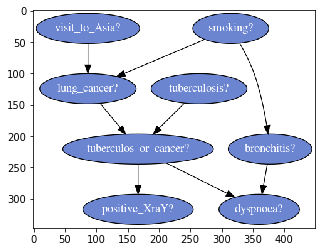

In [58]:
display_BN ( names, bn_struct, "asia", style )


## 8. Fin de l'apprentissage et calcul probabiliste (Partie optionnelle)

Comme précisé au début du TME, apprendre un réseau bayésien consiste à déterminer sa structure graphique et estimer ses paramètres. Vous avez réalisé la première partie. La deuxième, plus simple, peut se faire par maximum de vraisemblance pour chaque table de probabilité des noeuds conditionnellement à leurs parents, comme dans le TME 3\. Utilisez la fonction **learn_parameters** ci-dessous pour effectuer cette tâche. Cette fonction prend en paramètres la structure graphique que vous avez apprise ainsi que le nom du fichier CSV que vous avez utilisé pour votre apprentissage. Elle renvoie un réseau bayésien à la [aGrUM](http://agrum.org). Pour pouvoir utiliser aGrUM, reportez-vous à la [question 7 du TME 2].


In [59]:
import pyAgrum as gum
import pyAgrum.lib.ipython as gnb


def learn_parameters ( bn_struct, ficname ):
    # création du dag correspondant au bn_struct
    graphe = gum.DAG ()
    nodes = [ graphe.addNode () for i in range ( bn_struct.shape[0] ) ]
    for i in range ( bn_struct.shape[0] ):
        for parent in bn_struct[i]:
            graphe.addArc ( nodes[parent], nodes[i] )

    # appel au BNLearner pour apprendre les paramètres
    learner = gum.BNLearner ( ficname )
    learner.useScoreLog2Likelihood ()
    learner.useAprioriSmoothing ()
    return learner.learnParameters ( graphe )


Vous pouvez maintenant réaliser des calculs probabilistes :

- affichage de la taille du réseau bayésien

```python
# création du réseau bayésien à la aGrUM
bn = learn_parameters ( bn_struct, ficname )

# affichage de sa taille
print(bn)
```

- affichage de la table de probabilité conditionnelle d'un noeud du réseau déterminé par son nom (1ère ligne du CSV):

```python

# récupération de la ''conditional probability table'' (CPT) et affichage de cette table
gnb.showPotential( bn.cpt ( bn.idFromName ( 'bronchitis?' ) ) )
```

- calcul de la probabilité marginale d'un noeud : P('bronchitis?'):


```python

# calcul de la marginale
proba = gum.getPosterior ( bn, {}, 'bronchitis?' )

```

- affichage graphique d'une distribution de probabilité marginale

```python
# affichage de la marginale
gnb.showPotential( proba )

```
- calcul d'une distribution marginale a posteriori : P(bronchitis? | smoking? = true, turberculosis? = false )
```python
gnb.showPotential(gum.getPosterior ( bn,{'smoking?': 'true', 'tuberculosis?' : 'false' }, 'bronchitis?' ))
```

In [63]:
ficname = "tme5_asia.csv" 

# création du réseau bayésien à la aGrUM
bn = learn_parameters ( bn_struct, ficname )

# affichage de sa taille
print(bn)

BN{nodes: 8, arcs: 8, domainSize: 256, dim: 38}


In [64]:
# récupération de la ''conditional probability table'' (CPT) et affichage de cette table
gnb.showPotential( bn.cpt ( bn.idFromName ( 'bronchitis?' ) ) )


      ||  bronchitis?      |
smokin||false    |true     |
------||---------|---------|
false || 0.6181  | 0.3819  |
true  || 0.2917  | 0.7083  |



In [66]:
# calcul de la marginale
proba = gum.getPosterior ( bn, {}, 'bronchitis?' )
print(proba)


  bronchitis?      |
false    |true     |
---------|---------|
 0.4551  | 0.5449  |



In [68]:
# affichage de la marginale
gnb.showPotential( proba )
gnb.showPotential(gum.getPosterior ( bn,{'smoking?': 'true', 'tuberculosis?' : 'false' }, 'bronchitis?' ))


  bronchitis?      |
false    |true     |
---------|---------|
 0.4551  | 0.5449  |


  bronchitis?      |
false    |true     |
---------|---------|
 0.2917  | 0.7083  |



## 9. (Bonus) Autres bases de données

Vous pouvez appliquer vos algorithmes sur des bases un peu plus conséquentes qu'asia:

|  nom de la base  |            provenance           | nombre d'evenements elementaires |
|:----------------:|:-------------------------------:|:--------------------------------:|
|       asia       |          BN repository          |                $256     $          |
|       alarm      |          BN repository          |              $10^{16}   $               |
|       adult      | UCI machine learning repository |              $10^{12}   $          |
|        car       | UCI machine learning repository |               $6912     $          |
| agaricus-lepiota | UCI machine learning repository |              $10^{16}   $        |



In [ ]:
# On a pas trouver les fichiere csv
#names, data, dico = read_csv ( "tme5_car.csv" )
#bn_struct = learn_BN_structure ( data, dico, 0.05 )